In [213]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import pickle

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [214]:
# Road network data of Seattle city
roads = gpd.read_file('https://opendata.arcgis.com/datasets/383027d103f042499693da22d72d10e3_0.geojson')

In [215]:
# Traffic volume data Seattle city road segments in 2016

volume = gpd.read_file('https://opendata.arcgis.com/datasets/170b764c52f34c9497720c0463f3b58b_9.geojson')

In [216]:
volume.rename(columns={'OBJECTID': 'SEGID'},inplace=True)

In [217]:
acc = pd.read_pickle('data/accident.pickle')

Text(0.5, 1.0, 'Seattle Road Network')

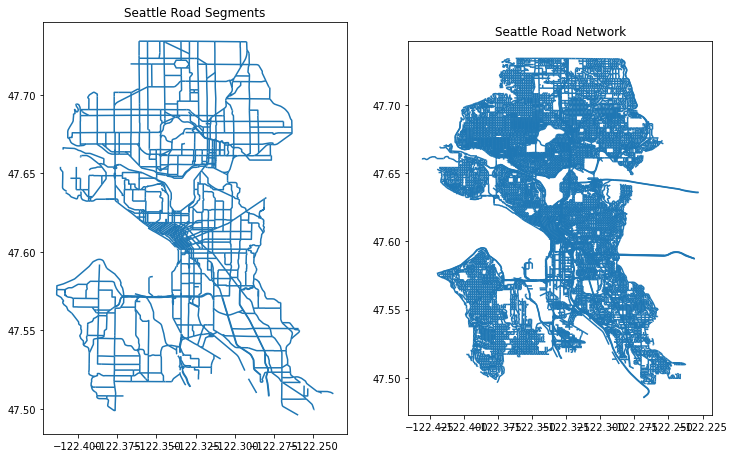

In [218]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12, 12))
volume.plot(ax = ax1)
ax1.set_title('Seattle Road Segments')
roads.plot(ax = ax2)
ax2.set_title('Seattle Road Network')

Text(0.5, 1.0, 'Accident map in 2016 Seattle')

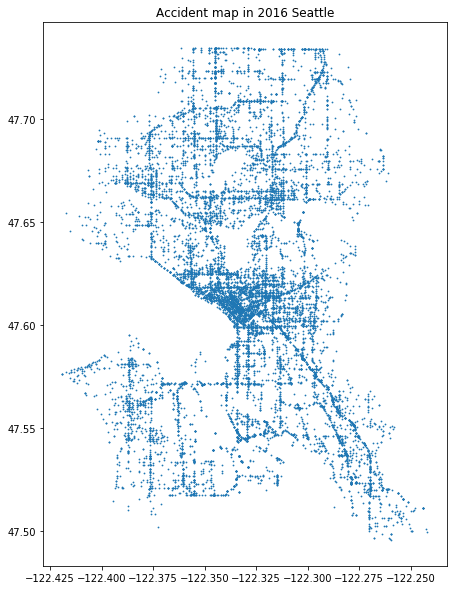

In [219]:
acc[acc['year']==2016].plot(markersize= 0.6, figsize = (12, 10))
plt.title('Accident map in 2016 Seattle')

In [220]:
roads.columns

Index(['OBJECTID', 'ARTCLASS', 'COMPKEY', 'UNITIDSORT', 'UNITDESC',
       'STNAME_ORD', 'XSTRLO', 'XSTRHI', 'ARTDESCRIPT', 'OWNER', 'STATUS',
       'BLOCKNBR', 'SPEEDLIMIT', 'SEGDIR', 'ONEWAY', 'ONEWAYDIR', 'FLOW',
       'SEGLENGTH', 'SURFACEWIDTH', 'SURFACETYPE_1', 'SURFACETYPE_2', 'INTRLO',
       'DIRLO', 'INTKEYLO', 'INTRHI', 'DIRHI', 'NATIONHWYSYS', 'STREETTYPE',
       'PVMTCONDINDX1', 'PVMTCONDINDX2', 'TRANCLASS', 'TRANDESCRIPT',
       'SLOPE_PCT', 'PVMTCATEGORY', 'PARKBOULEVARD', 'SHAPE_Length',
       'geometry'],
      dtype='object')

In [221]:
volume.columns


Index(['SEGID', 'COUNT_COMPKEY', 'FIRST_STNAME_ORD', 'FIRST_ARTDESCRIPT',
       'FIRST_TRANDESCRIPT', 'COUNTFLAG', 'FLOWSEGID', 'DOWNTOWN',
       'COUNTSTART', 'COUNTAADT', 'COUNTAAWDT', 'ESTIMATE', 'AWDT_ROUND',
       'SHAPE_Length', 'geometry'],
      dtype='object')

In [222]:
# nearest road blocks to each road segment

'''
dist = []
for segment in volume.geometry:
    d = []
    for block in roads.geometry:
        d.append(segment.distance(block))
    d = np.array(d)
    dist.append(d.argmin())
    
'''

'\ndist = []\nfor segment in volume.geometry:\n    d = []\n    for block in roads.geometry:\n        d.append(segment.distance(block))\n    d = np.array(d)\n    dist.append(d.argmin())\n    \n'

In [223]:
# saving minimum distances to a csv file
# np.savetxt('segment_net.csv', dist, fmt="%d", delimiter=",")

In [224]:
# need to come up with a better solutin to assign each road segment to the road network map

""""
dist = []
for idx, segment in enumerate(volume.geometry):
    d = []
    for i, block in enumerate(roads.geometry[:10]):
        d.append(segment.distance(block))
    d = np.array(d)
    for j in d.argsort()[:5]:
        if volume.iloc[j]['FIRST_STNAME_ORD'] == roads.iloc[j]['STNAME_ORD']:
            dist.append(j)
"""

'"\ndist = []\nfor idx, segment in enumerate(volume.geometry):\n    d = []\n    for i, block in enumerate(roads.geometry[:10]):\n        d.append(segment.distance(block))\n    d = np.array(d)\n    for j in d.argsort()[:5]:\n        if volume.iloc[j][\'FIRST_STNAME_ORD\'] == roads.iloc[j][\'STNAME_ORD\']:\n            dist.append(j)\n'

In [225]:
# creating "SEGID" column in network

dist = pd.read_csv('segment_net_indices.csv', header = None).values

network = roads.iloc[dist.flatten()]
network.loc[:, 'SEGID'] = volume['SEGID'].values


/Users/gulomjon/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gulomjon/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [226]:
network.shape


(1865, 38)

In [227]:
network.head()

,OBJECTID,ARTCLASS,COMPKEY,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIPT,OWNER,...,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,PARKBOULEVARD,SHAPE_Length,geometry,SEGID
1923,1924,2.0,21309,169700001,S SPOKANE NR ST BETWEEN S SPOKANE ST RP AND EA...,S SPOKANE ST,S SPOKANE ST RP,EAST MARGINAL WAY S,Minor Arterial,,...,91.0,0.0,2,MAJOR TRANSIT ROUTE,0.0,ART,N,927.672370,LINESTRING (-122.3434333838131 47.571579040261...,1
3408,3409,1.0,8766,050650220,ALASKAN WY VI NB BETWEEN EAST MARGINAL WAY S A...,SR99 NB,EAST MARGINAL WAY S,ALASKAN WY VI NB ON RP,Principal Arterial,WSDOT,...,0.0,0.0,2,MAJOR TRANSIT ROUTE,0.0,ART,N,1605.935350,LINESTRING (-122.3394359392448 47.566345148158...,2
3403,3404,3.0,8715,050710010,ALASKAN WY VI SB WSB WB OFF RP BETWEEN ALASKAN...,SR99 SB OFF RP,ALASKAN WY VI SB,WEST SEATTLE BR WB,Collector Arterial,WSDOT,...,100.0,0.0,0,NOT DESIGNATED,0.0,ART,N,1319.086025,LINESTRING (-122.3393934889239 47.573037386120...,3
1923,1924,2.0,21309,169700001,S SPOKANE NR ST BETWEEN S SPOKANE ST RP AND EA...,S SPOKANE ST,S SPOKANE ST RP,EAST MARGINAL WAY S,Minor Arterial,,...,91.0,0.0,2,MAJOR TRANSIT ROUTE,0.0,ART,N,927.672370,LINESTRING (-122.3434333838131 47.571579040261...,4
1922,1923,2.0,21305,169570050,S SPOKANE CR ST BETWEEN S SPOKANE NR ST AND 6T...,S SPOKANE CR ST,S SPOKANE NR ST,6TH AVE S,Minor Arterial,,...,98.0,0.0,2,MAJOR TRANSIT ROUTE,0.0,ART,N,199.159007,LINESTRING (-122.3267633109531 47.571695311514...,5


In [228]:
volume.head()

,SEGID,COUNT_COMPKEY,FIRST_STNAME_ORD,FIRST_ARTDESCRIPT,FIRST_TRANDESCRIPT,COUNTFLAG,FLOWSEGID,DOWNTOWN,COUNTSTART,COUNTAADT,COUNTAAWDT,ESTIMATE,AWDT_ROUND,SHAPE_Length,geometry
0,1,None,S SPOKANE ST,None,None,Y,2019.0,N,2015-04-03T00:00:00,5508.833000,6829.504000,None,6800.0,1118.471355,LINESTRING (-122.3396800681195 47.571700326672...
1,2,None,BATTERY ST TUNNEL NB,None,None,Y,2023.0,N,2015-06-09T00:00:00,27080.835000,28793.392000,None,28800.0,1605.935119,LINESTRING (-122.3392266031084 47.570739990412...
2,3,None,ALASKAN WY VI SB,None,None,Y,2024.0,N,2015-06-09T00:00:00,0.000000,23393.664000,None,23400.0,2441.189454,LINESTRING (-122.3394359390524 47.566345148425...
3,4,None,S SPOKANE ST RP,None,None,Y,2025.0,N,2015-06-09T00:00:00,3622.684000,4421.927000,None,4400.0,1214.542393,LINESTRING (-122.3434333843779 47.571579040153...
4,5,None,WEST SEATTLE BR WB,None,None,Y,2026.0,N,2014-04-29T00:00:00,46875.085335,50036.029406,None,50000.0,1817.352489,LINESTRING (-122.333137393517 47.5715774100566...


In [229]:
y15 = acc[acc['year']==2015]

In [230]:
y15.shape

(13555, 33)

In [231]:
y16 = acc[acc['year']==2016]

In [232]:
y16.shape

(13233, 33)

In [233]:
# total traffic volume by road segment for 2016 
count16 = y16.groupby('SEGID')['AWDT_ROUND'].count().to_frame(name = 'count')


In [234]:
# total traffic volume by road segment for 2015
count15 = y15.groupby('SEGID')['AWDT_ROUND'].count().to_frame(name = 'count')

In [235]:
two_year = count15.merge(count16, on = 'SEGID')

In [236]:
two_year.rename(columns={'count_x': 'count_15', 'count_y': 'count_16'}, inplace=True)

In [237]:
#volume.drop('count', inplace=True, axis = 1)

In [238]:
volume = volume.merge(two_year, on = 'SEGID')
volume.head()

,SEGID,COUNT_COMPKEY,FIRST_STNAME_ORD,FIRST_ARTDESCRIPT,FIRST_TRANDESCRIPT,COUNTFLAG,FLOWSEGID,DOWNTOWN,COUNTSTART,COUNTAADT,COUNTAAWDT,ESTIMATE,AWDT_ROUND,SHAPE_Length,geometry,count_15,count_16
0,1,None,S SPOKANE ST,None,None,Y,2019.0,N,2015-04-03T00:00:00,5508.833000,6829.504000,None,6800.0,1118.471355,LINESTRING (-122.3396800681195 47.571700326672...,11,7
1,3,None,ALASKAN WY VI SB,None,None,Y,2024.0,N,2015-06-09T00:00:00,0.000000,23393.664000,None,23400.0,2441.189454,LINESTRING (-122.3394359390524 47.566345148425...,4,3
2,5,None,WEST SEATTLE BR WB,None,None,Y,2026.0,N,2014-04-29T00:00:00,46875.085335,50036.029406,None,50000.0,1817.352489,LINESTRING (-122.333137393517 47.5715774100566...,10,4
3,6,None,WEST SEATTLE BR EB,None,None,Y,2027.0,N,None,NaN,35000.000000,Y,35000.0,1423.838986,LINESTRING (-122.3309157221583 47.571518426658...,3,1
4,7,None,W SEA BR EB 4 AV OFF RP,None,None,Y,2028.0,N,None,NaN,24000.000000,Y,24000.0,1458.971527,LINESTRING (-122.3309157221583 47.571518426658...,1,2


In [239]:
#volume['rate'] = volume['count']/(volume['AWDT_ROUND']*365)


In [240]:
# final dataframe 
final = volume[['SEGID', 'FIRST_STNAME_ORD', 'AWDT_ROUND','geometry','count_15', 'count_16']].merge(network, how = 'left', on = 'SEGID')


In [241]:
final.columns

Index(['SEGID', 'FIRST_STNAME_ORD', 'AWDT_ROUND', 'geometry_x', 'count_15',
       'count_16', 'OBJECTID', 'ARTCLASS', 'COMPKEY', 'UNITIDSORT', 'UNITDESC',
       'STNAME_ORD', 'XSTRLO', 'XSTRHI', 'ARTDESCRIPT', 'OWNER', 'STATUS',
       'BLOCKNBR', 'SPEEDLIMIT', 'SEGDIR', 'ONEWAY', 'ONEWAYDIR', 'FLOW',
       'SEGLENGTH', 'SURFACEWIDTH', 'SURFACETYPE_1', 'SURFACETYPE_2', 'INTRLO',
       'DIRLO', 'INTKEYLO', 'INTRHI', 'DIRHI', 'NATIONHWYSYS', 'STREETTYPE',
       'PVMTCONDINDX1', 'PVMTCONDINDX2', 'TRANCLASS', 'TRANDESCRIPT',
       'SLOPE_PCT', 'PVMTCATEGORY', 'PARKBOULEVARD', 'SHAPE_Length',
       'geometry_y'],
      dtype='object')

In [242]:
final.STREETTYPE.unique()

array(['Industrial Access', None, 'Urban Center Connector',
       'Urban Village Main', 'Neighborhood Corridor',
       'Urban Village Neighborhood Access', 'Urban Village Neighborhood',
       'Neighborhood Yield Street', 'Minor Industrial Access', 'Downtown',
       'Downtown Neighborhood', 'Downtown Neighborhood Access', 'Alley'],
      dtype=object)

In [243]:
def downtown(df_in):
    downtown = set(['Downtown', 'Downtown Neighborhood', 'Downtown Neighborhood Access'])
    
    new_df = df_in.copy()
    new_df['downtown'] = df_in['STREETTYPE'].apply(lambda x: 1 if x in downtown else 0)
    #new_df.drop('acct_type', axis=1, inplace=True)
    return new_df

In [244]:
new_final = downtown(final)

In [245]:
#new_final.ONEWAY = new_final.ONEWAY.astype(int)

new_final['ONEWAY'] = new_final['ONEWAY'].apply(lambda x: 1 if x == 'Y' else 0)

In [246]:
new_final.columns

Index(['SEGID', 'FIRST_STNAME_ORD', 'AWDT_ROUND', 'geometry_x', 'count_15',
       'count_16', 'OBJECTID', 'ARTCLASS', 'COMPKEY', 'UNITIDSORT', 'UNITDESC',
       'STNAME_ORD', 'XSTRLO', 'XSTRHI', 'ARTDESCRIPT', 'OWNER', 'STATUS',
       'BLOCKNBR', 'SPEEDLIMIT', 'SEGDIR', 'ONEWAY', 'ONEWAYDIR', 'FLOW',
       'SEGLENGTH', 'SURFACEWIDTH', 'SURFACETYPE_1', 'SURFACETYPE_2', 'INTRLO',
       'DIRLO', 'INTKEYLO', 'INTRHI', 'DIRHI', 'NATIONHWYSYS', 'STREETTYPE',
       'PVMTCONDINDX1', 'PVMTCONDINDX2', 'TRANCLASS', 'TRANDESCRIPT',
       'SLOPE_PCT', 'PVMTCATEGORY', 'PARKBOULEVARD', 'SHAPE_Length',
       'geometry_y', 'downtown'],
      dtype='object')

In [247]:
sum(new_final.AWDT_ROUND.isna())

2

In [248]:
reg_data = new_final[['SPEEDLIMIT', 'SURFACEWIDTH', 'count_15', 'count_16', 'SLOPE_PCT', 'downtown', 'ONEWAY', 'AWDT_ROUND']]
reg_data.dropna(how = 'all', inplace = True)


/Users/gulomjon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [249]:
sum(reg_data['SLOPE_PCT'].isna())

4

In [250]:
reg_data.loc[:, 'SLOPE_PCT'] = reg_data['SLOPE_PCT'].fillna(reg_data['SLOPE_PCT'].mean())

In [251]:
reg_data.loc[:, 'AWDT_ROUND'] = reg_data['AWDT_ROUND'].fillna(reg_data['AWDT_ROUND'].mean())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2207c898>,
      dtype=object)

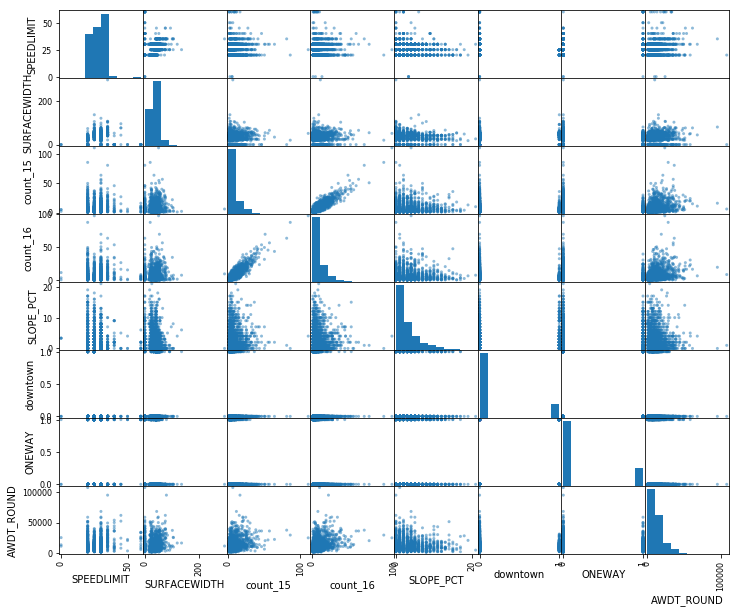

In [252]:
pd.plotting.scatter_matrix(reg_data, figsize= (12, 10))

In [203]:
# Run the regression on year 16

X = reg_data[['count_15','SPEEDLIMIT',  'downtown', 'AWDT_ROUND']]
y = reg_data['count_16']


In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

In [253]:
linreg = LinearRegression()
results = linreg.fit(X_train, y_train)

In [254]:
results.score(X_train, y_train)

0.8124463422649257

In [255]:
results.score(X_test, y_test)

0.7126695195409486

In [256]:
mean_squared_error(y_train, results.predict(X_train))**0.5

4.137755855148988

In [257]:
mean_squared_error(y_test, results.predict(X_test))**0.5

4.134633790145607

In [258]:
# baseline 

In [274]:
y_15 = np.ones(X.shape[0])*X['count_15']

In [275]:
y_15

array([8.74507227, 8.74507227, 8.74507227, ..., 8.74507227, 8.74507227,
       8.74507227])

In [277]:
mean_squared_error(y, X['count_15'])**0.5

4.31389893800332

In [ ]:
# Gradient boosting regressor


In [288]:
gb = GradientBoostingRegressor()

In [289]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [291]:
mean_squared_error(y_test, gb.predict(X_test))**0.5

4.201313038907296

In [145]:
# OLS

In [262]:
sm_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [263]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               count_16   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     1098.
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:25:46   Log-Likelihood:                -2893.0
No. Observations:                1019   AIC:                             5796.
Df Residuals:                    1014   BIC:                             5821.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7150      0.655      1.092      0.275      -0.570       2.000
count_15       0.8832      0.014     61.877      0.000       0.855       0.911
SPEEDLIMIT    -0.0149      0.023     -0.638      0.524      -0.061       0.031
downtown      -0.4232      0.352     -1.201      0.230      -1.115       0.268
AWDT_ROUND  4.276e-05   1.38e-05      3.107      0.002    1.58e-05    6.98e-05
==============================================================================
Omnibus:                      110.087   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              371.335
Skew:                           0.499   Prob(JB):                     2.32e-81
Kurtosis:                       5.784   Cond. No.                     8.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [212]:
reg_data.corr()

,SPEEDLIMIT,SURFACEWIDTH,count_15,count_16,SLOPE_PCT,downtown,ONEWAY,AWDT_ROUND
SPEEDLIMIT,1.000000,0.168681,-0.013375,-0.013967,-0.143463,-0.157958,0.104008,0.139235
SURFACEWIDTH,0.168681,1.000000,-0.001342,0.004010,-0.129647,0.159430,-0.069274,0.068810
count_15,-0.013375,-0.001342,1.000000,0.886491,-0.044577,-0.172433,-0.185193,0.280217
count_16,-0.013967,0.004010,0.886491,1.000000,-0.066558,-0.174932,-0.172841,0.296375
SLOPE_PCT,-0.143463,-0.129647,-0.044577,-0.066558,1.000000,0.090929,0.052650,-0.102940
downtown,-0.157958,0.159430,-0.172433,-0.174932,0.090929,1.000000,0.440029,-0.099031
ONEWAY,0.104008,-0.069274,-0.185193,-0.172841,0.052650,0.440029,1.000000,-0.039159
AWDT_ROUND,0.139235,0.068810,0.280217,0.296375,-0.102940,-0.099031,-0.039159,1.000000


In [284]:
regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=50)

In [285]:
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [287]:
mean_squared_error(y_test, regr.predict(X_test))**0.5

4.209627050941386

# Let's try Random Forest Regression

In [51]:
# Let's establish a baseline for Random Forest using the mean value for the target

# Now let's standardize the features

In [52]:
scaler = StandardScaler()
print(scaler.fit(X))
print(scaler.mean_)


StandardScaler(copy=True, with_mean=True, with_std=True)
[26.40604468 35.98028909  3.33135705  0.17871222  0.217477  ]


/Users/gulomjon/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


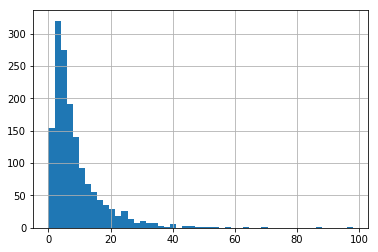

In [282]:
y.hist(bins = 50)

In [283]:
y.mean()

8.519053876478319

In [ ]:
acc.groupby('year')['FATALITIES'].sum()

In [ ]:
acc.groupby('year')['FATALITIES'].sum().hist()

#  Let's put the predicted road segments on the map

In [ ]:
danger_roads = final.sort_values('rate')

In [ ]:
danger_idx = danger_roads.index[:100]

In [ ]:

fig, ax = plt.subplots(figsize = (8, 10))
volume.plot(ax = ax, alpha = 0.4, color = 'grey')
volume.iloc[danger_idx].plot(ax = ax, color = 'red', label = 'Risky Roads')
#plt.legend(prop = {'size':15})
plt.title('2016 New Years Eve')



In [ ]:
volume[['count', 'COUNTAAWDT']].corr()